# COMS4061A - Reinforcement Learning

## Multi-Armed Bandits - Exercise

### Imports

In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
%matplotlib inline

### Interface class

In [18]:
class MAB(ABC):
    def __init__(self, arms):
        self.arms = arms
        self.means = np.random.normal(0, 3, arms)
        self.var = 1
        
    @abstractmethod
    def pull(self):
        pass
    
    def run_experiment(self, iterations):
        mean_rewards_timestep = np.empty(iterations)
        
        mean_reward = 0
        for i in range(iterations):
            reward = self.pull()
            n = i + 1
            mean_reward = mean_reward + (reward - mean_reward) / n
            mean_rewards_timestep[i] = mean_reward
        
        return mean_rewards_timestep

### Epsilon Greedy

In [41]:
class EpsilonGreedy(MAB):
    def __init__(self, arms, epsilon, q1 = 0):
        super().__init__(arms)
        self.epsilon = epsilon
        self.q1 = q1
        self.mean_rewards = np.full(arms, q1)
        self.num_runs = np.zeros(arms)
        
    def __str__(self):
        info = f"arms = {self.arms}\n"
        info += f"ε = {self.epsilon}\n"
        info += f"Q1 = {self.q1}\n"
        info += f"mean rewards / arm = {self.mean_rewards}\n"
        info += f"number of runs / arm = {self.num_runs}\n"
        info += f"rewards / timestep = {self.rewards}"
        info += "\n"
        return info
    
    def pull(self):
        # Choose Action
        p = np.random.random()
        if (p < self.epsilon):
            action = np.random.choice(self.arms)
        else:
            action = np.argmax(self.mean_rewards)
            
        # Get reward
        reward = np.random.normal(self.means[action], self.var)
        
        # Update model
        self.num_runs[action] += 1
        self.mean_rewards[action] = self.mean_rewards[action] + (reward - self.mean_rewards[action]) / self.num_runs[action]
        
        return reward

### Upper Confidence Bounds (UCB)

In [42]:
class UCB(MAB):
    def __init__(self, arms, c):
        super().__init__(arms)
        self.c = c
        self.mean_rewards = np.zeros(arms)
        self.num_runs = np.zeros(arms)
        self.t = 1
        
    def get_max_arm(self):
        max_upper_bound, max_arm = 0, -1
        for arm in range(self.arms):
            upper_bound = self.mean_rewards[arm] + math.sqrt(math.log(self.t) / self.num_runs[arm]) if self.num_runs[arm] > 0 else float('inf') 
        
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                max_arm = arm
                
        return (max_upper_bound, max_arm)
        
    def pull(self):
        # Choose action
        _, max_arm = self.get_max_arm()
        
        if max_arm == -1:
            raise Exception("No arm was selected!!")
        
        # Get reward
        reward = np.random.normal(self.means[max_arm], self.var)
        
        # Update model
        self.mean_rewards[max_arm] = (self.mean_rewards[max_arm] * self.num_runs[max_arm] + reward) / (self.num_runs[max_arm] + 1)
        self.num_runs[max_arm] += 1
        
        self.t += 1
        
        return reward

### Experiment runs

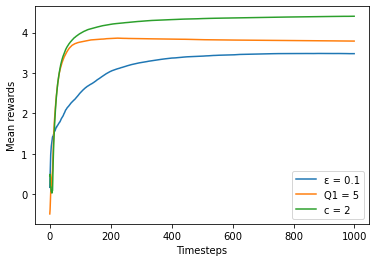

In [40]:
runs = 100
iterations = 1000
timesteps = np.arange(iterations)

epsilon_greedy_results = []
optimistic_init_results = []
ucb_results = []

for r in range(runs):
    eg = EpsilonGreedy(arms = 10, epsilon = 0.1)
    epsilon_greedy_results.append(eg.run_experiment(iterations))
    
    
    og = EpsilonGreedy(arms = 10, epsilon = 0, q1 = 5)
    optimistic_init_results.append(og.run_experiment(iterations))
    
    
    ucb = UCB(arms = 10, c = 2)
    ucb_results.append(ucb.run_experiment(iterations))

plt.plot(timesteps, np.mean(epsilon_greedy_results, axis=0), label = 'ε = 0.1')
plt.plot(timesteps, np.mean(optimistic_init_results, axis=0), label = 'Q1 = 5')
plt.plot(timesteps, np.mean(ucb_results, axis=0), label = 'c = 2')

plt.ylabel('Mean rewards')
plt.xlabel('Timesteps')

plt.legend()
plt.show()